# Diffusion Benchmark Tutorial

This notebook provides a tutorial on benchmarking numerical solutions to the diffusion equation against well-established analytical solutions. 

It demonstrates the use of the finite element method via underworld3 and compares numerical results to the analytical model described by Crank (1975). 

------

First we import the required modules

In [1]:
import os
import time

In [2]:
os.environ["UW_TIMING_ENABLE"] = "1"
from underworld3 import timing

In [3]:
import underworld3 as uw
import UWDiffusion as DIF

In [4]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt

------
We include the timing in this script to see how the model performs

In [5]:
timing.reset()
timing.start()
time_start = time.time()

------
Here we setup some parameters for the model for the unknown and discretisation of the domain.


These can either be modified in the script or specified in the command line, e.g. 
`python3 Diffusion-benchmark.py -uw_csize 0.01` 
to modify the cell cize to 0.01

In [6]:
U_degree    = uw.options.getInt("U_degree", default=1)
continuous  = uw.options.getBool("continuous", default=True)

order = uw.options.getInt("order", default=2)

csize       = uw.options.getReal("csize", default=0.01)

tolerance   = uw.options.getReal("tolerance", default=1e-6)


save_figs    = uw.options.getBool("save_figs", default=False)

CFL_fac      = uw.options.getReal("CFL_fac", default=0.5)

dt_max = uw.options.getInt("dt_max", default=1) ### Myr

if uw.mpi.rank == 0:
    print(f'csize = {csize}, CFL = {CFL_fac}, degree = {U_degree}')

csize = 0.01, CFL = 0.5, degree = 1


------
Here we setup some parameters of the model to test against the benchmark. Modifying these parameters will automatically update the analytical solution.

In [7]:
T_start = uw.options.getReal("T_start", default=850) ### C

t_end   = uw.options.getReal("t_end", default=10.95) ### Myr, ND to 1e-4

x0_c = uw.options.getReal("x0", default=0.35) ### start of heat pipe
x1_c = uw.options.getReal("x1", default=0.65) ### end of heat pipe

outputPath  = uw.options.getString('outputPath', default=f'./output/Diffusion-T={T_start}C-t={t_end}Myr-degree={U_degree}-csize={csize}-CFL={CFL_fac}/')


if uw.mpi.rank == 0:
    os.makedirs(outputPath, exist_ok=True)

#### The diffusion coefficient (D)
------
Here we outline the variables to determine the diffusion coefficient for U and Pb. We use sympy to generate a symbolic equation and substitute the values in.

-----
Table of variables to determine the diffusion coefficient for each element
| Variable | Symbol            | units | U | Pb | 
| :---------- | :-------: | :-------: | :------: |  ------: | 
| Pre-exponent| $D_0$   | $\text{m}^2\, \text{s}^{-1}$ |  1.63   | 0.11 |
| Activation energy | $E_a$  | $\text{kJ}\, \text{mol}^{-1}$ |  726 $\pm$ 83    |  550 $\pm$ 30  |
| Gas constant | $R$  | $\text{J}\, \text{mol}^{-1}\, \text{K}^{-1}$ |  8.314    | 8.314 | 
| Reference | |  | [Cherniak and Watson, 1997](http://link.springer.com/10.1007/s004100050287) | [Cherniak and Watson, 2001](https://www.sciencedirect.com/science/article/pii/S0009254100002333) | [Cherniak and Watson, 2007](https://www.sciencedirect.com/science/article/pii/S0009254107002148) | 

In [8]:
D, E, R, T = sp.symbols('D E R T') # Temperature in Kelvin

D_sym = D * sp.exp(-E / (R * (T+ 273.15) ) )

In [9]:
def diffusivity_fn(D_sym, D0, Ea):
    D_exp = D_sym.subs({D: D0, E: Ea, R: 8.314}).simplify()
    return sp.lambdify(T, D_exp, 'numpy')

D_Pb_fn = diffusivity_fn(D_sym, D0=0.11, Ea=550e3)
D_U_fn = diffusivity_fn(D_sym, D0=10**0.212, Ea=726e3)

#### Scaling the model
------
Numerical models are easier to solve when non-dimensionalised. Here we use pint to set some scaling coefficients that can be used to non-dimensionalise values used in the model.

-----

In [10]:
# import unit registry
u = uw.scaling.units

### make scaling easier
ndim, nd = uw.scaling.non_dimensionalise, uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 


diffusive_rate    = D_Pb_fn(T_start) * u.meter**2 /u.second
model_length      = 100 * u.micrometer ### scale the mesh radius to the zircon radius


KL = model_length
Kt = model_length**2 / diffusive_rate


scaling_coefficients  = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt

scaling_coefficients

[mass],1.0 kilogram
[length],9.999999999999999e-05 meter
[temperature],1.0 kelvin
[time],3.4556480968067374e+18 second
[substance],1.0 mole


#### The analytical solution
------
Here we use sympy to setup the analytical solution. We can then substitute values in when determining the analytical profile.

-----

In [11]:
v, t, x, x0, x1, ka = sp.symbols('u, t, x_c, x0, x1, kappa')

U_a_x = 0.5 * (
    sp.erf((x1 - x + (v*t)) / (2 * sp.sqrt(ka*t))) +
    sp.erf((-x0 + x - (v*t)) / (2 * sp.sqrt(ka*t)))
)

------
Here we plot the initial distribution of the unknown we want to solve for and compare with the analytical solution

-----

In [12]:
if save_figs:
    
    x_arr = np.linspace(0, 1, 100)
    y_arr = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x_arr, y_arr)
    Z = np.zeros_like(X) 
    Z[(X>=x0_c) & (X<=x1_c)] = 1
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 4))
    cmap = plt.cm.viridis  # Use the viridis colormap
    norm = plt.Normalize(vmin=0, vmax=1) 
    
    # Plot the data
    contour = ax.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap=cmap, norm=norm)
    
    # Add the colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical')  # or 'horizontal'

    cbar.set_ticks(np.linspace(0, 1, 11) )
    
    # Add labels and title
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_aspect('equal')
    
    
    # Show the plot
    # plt.tight_layout()

    plt.savefig(f'{outputPath}Initial_condition.pdf', bbox_inches='tight')
    
    # plt.show()

------
We also plot the final condition from the analytical solution to determine what the output *should* look like.

-----

In [13]:
if save_figs:
    
    # Compute the analytical solution
    Z = 0.5 * (
        erf((x1_c - X) / (2 * np.sqrt(1 * nd(t_end*u.megayear)))) +
        erf((-x0_c + X) / (2 * np.sqrt(1 * nd(t_end*u.megayear))))
    )

    
    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 4))
    cmap = plt.cm.viridis  # Use the viridis colormap
    norm = plt.Normalize(vmin=0, vmax=1) 
    
    # Plot the data
    contour = ax.contourf(Z, extent=[0, 1, 0, 1], origin='lower', cmap=cmap, norm=norm, levels=901)
    
    # Add the colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical')  # or 'horizontal'
    cbar.set_ticks(np.linspace(0, 1, 11) )
    
    # Add labels and title
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_aspect('equal')

    contour.set_edgecolor("face")
    
    
    # Show the plot
    # plt.tight_layout()

    plt.savefig(f'{outputPath}Final_condition.pdf', bbox_inches='tight')
    
    plt.show()

------
we setup the mesh, which we want to solve the solution on.

-----

In [14]:
mesh = uw.meshing.UnstructuredSimplexBox(minCoords=(0,0), maxCoords=(1,1), cellSize=csize, qdegree=U_degree)

------
we also setup the initial distribution using a sympy Piecewise function, using _mesh.X[0]_ to represent the _x_ coordinate in the domain

-----

In [15]:
init_dist = sp.Piecewise( (0, mesh.X[0] < x0_c), (1, (mesh.X[0] >= x0_c) & (mesh.X[0] <= x1_c)), (0, mesh.X[0] > x1_c) )

------
Here we set up out difffusion model, which creates a diffusion solver and sets the model up under the hood.

-----

In [16]:
Pb_diffusion = DIF.DiffusionModel('Pb', mesh, degree=U_degree, order=order)

#### We need to set the initial value across the domain
-----
We do this by accessing the mesh variable for the model

In [17]:
with Pb_diffusion.mesh.access(Pb_diffusion.mesh_var):
    Pb_diffusion.mesh_var.data[:,0] = uw.function.evaluate(init_dist, Pb_diffusion.mesh_var.coords).flatten()

------
The diffusivity of the model needs to be set, which can be set through _*.diffusivity_

-----

In [18]:
Pb_diffusion.diffusivity = D_Pb_fn(T_start) * u.meter**2 / u.second

------
We add in some PETSc options for the tolerance of the model

-----

In [19]:
for _solver in [Pb_diffusion]:
    _solver.diffusion_solver.petsc_options["snes_rtol"]   = tolerance*1e-4
    _solver.diffusion_solver.petsc_options["snes_atol"]   = tolerance
    _solver.diffusion_solver.petsc_options["ksp_atol"]    = tolerance
    _solver.diffusion_solver.petsc_options["snes_max_it"] = 100
    _solver.diffusion_solver.petsc_options["snes_monitor_short"] = None

------
Here we run the simulation, specifying how long to run the model for _(duration)_ and the timestep _(dt_max)_. If no timestep is specified, the timestep will be determined by the diffusivity and mesh cell size.

-----

In [30]:
Pb_diffusion.run_simulation(duration=(t_end*2)*u.megayear, time_step_factor=CFL_fac)


Step 12, dt: 0.9819400994344246 megayear, Time: 10.95 megayear
  0 SNES Function norm 823.881
  1 SNES Function norm 0.0154652
  2 SNES Function norm 4.49872e-06

Step 13, dt: 0.9819400994344246 megayear, Time: 11.93 megayear
  0 SNES Function norm 823.007
  1 SNES Function norm 0.0153153
  2 SNES Function norm 4.42654e-06

Step 14, dt: 0.9819400994344246 megayear, Time: 12.91 megayear
  0 SNES Function norm 822.121
  1 SNES Function norm 0.0151715
  2 SNES Function norm 4.35998e-06

Step 15, dt: 0.9819400994344246 megayear, Time: 13.90 megayear
  0 SNES Function norm 821.25
  1 SNES Function norm 0.015038
  2 SNES Function norm 4.30038e-06

Step 16, dt: 0.9819400994344246 megayear, Time: 14.88 megayear
  0 SNES Function norm 820.4
  1 SNES Function norm 0.0149153
  2 SNES Function norm 4.24725e-06

Step 17, dt: 0.9819400994344246 megayear, Time: 15.86 megayear
  0 SNES Function norm 819.572
  1 SNES Function norm 0.0148026
  2 SNES Function norm 4.19972e-06

Step 18, dt: 0.9819400994

------
The cells below evaluates the numerical result across the domain at the positions defined.

-----

In [31]:
sample_x = np.linspace(0, 1, 100)
sample_y = np.zeros_like(sample_x) + 0.5
sample_coords = np.column_stack([sample_x, sample_y])

In [32]:

Pb_subbed = U_a_x.subs({v:0, t:nd((t_end*2) *u.megayear), x:mesh.X[0], x0 : x0_c, x1 : x1_c, ka:nd(D_Pb_fn(T_start) * u.meter**2 /u.second )})

Pb_diffusion_profile = uw.function.evaluate(Pb_subbed, sample_coords).flatten()

In [33]:
UW_Pb_profile = uw.function.evaluate(Pb_diffusion.mesh_var.sym[0], sample_coords).flatten()

------
Here we compare the analytical result with that obtained from the numerical model

-----

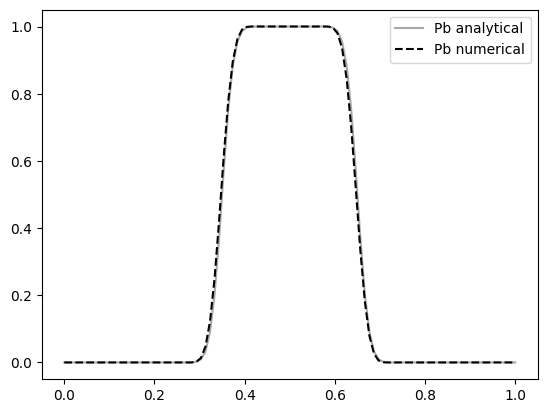

In [34]:
if uw.is_notebook:
    fig, ax = plt.subplots(1,1)
    ax.plot(sample_x, Pb_diffusion_profile, c='darkgray', label='Pb analytical')
    ax.plot(sample_x, UW_Pb_profile, ls='--', c='k', label='Pb numerical')
    
    ax.legend()

    if save_figs:
        plt.savefig(f'{outputPath}profile_comparison.pdf', bbox_inches="tight")
    
    plt.show()

------
Here we plot the error across the domain

-----

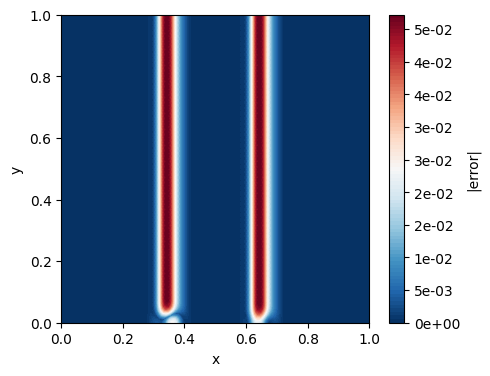

In [35]:
if uw.is_notebook:
    fig, ax = plt.subplots(figsize=(5, 4))
    
    with Pb_diffusion.mesh.access(Pb_diffusion.mesh_var):
        Pb_error = Pb_diffusion.mesh_var.data[:, 0] - uw.function.evaluate(Pb_subbed, Pb_diffusion.mesh_var.coords).flatten()

    
    
    
    x_coord = Pb_diffusion.mesh_var.coords[:, 0]
    y_coord = Pb_diffusion.mesh_var.coords[:, 1]
    
    contour0  = ax.tricontourf(x_coord, y_coord, np.abs(Pb_error), levels=100, cmap='RdBu_r')
    
    
    plt.colorbar(contour0, ax=ax, format='%.0e', label='|error|')
    
    contour0.set_edgecolors("face")
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_aspect('equal')
    
    if save_figs:
        plt.savefig(f'{outputPath}Pb_error_across_domain.pdf', bbox_inches="tight")



------
Here we calculate the L2-norm across the domain between the analytical and numerical results, and save the results to a csv file.

-----

In [27]:
Pb_l2_norm = uw.maths.L2_norm(Pb_diffusion.mesh_var.sym[0], Pb_subbed, mesh)

In [28]:
time_end = time.time()

total_time = time_end - time_start

In [29]:
if uw.mpi.rank == 0:
    import pandas as pd
    timing_data = uw.timing.get_summary()
    rows = []

    if isinstance(timing_data, dict) and "events" in timing_data:
        for location, count, elapsed, percent in timing_data["events"]:
            rows.append({
                "Location": location,
                "Count": count,
                "Time": elapsed,
                "Percent": percent,
                "Average": (elapsed / count) if count else np.nan,
            })
    elif hasattr(timing_data, "items"):
        for key, value in timing_data.items():
            location = key[0] if isinstance(key, tuple) and len(key) > 0 else str(key)
            index = key[1] if isinstance(key, tuple) and len(key) > 1 else np.nan

            if isinstance(value, tuple) and len(value) >= 2:
                count, elapsed = value[0], value[1]
            else:
                count, elapsed = np.nan, np.nan

            rows.append({
                "Location": location,
                "Index": index,
                "Count": count,
                "Time": elapsed,
                "Average": (elapsed / count) if count not in [0, np.nan] else np.nan,
            })

    df = pd.DataFrame(rows)
    if not df.empty and "Average" in df.columns:
        df.sort_values(by="Average", inplace=True, ascending=False)
    df.to_csv(f"{outputPath}/Diffusion_results_columns.csv", index=False)
    
    summary = {
        "U_degree": U_degree,
        "n_unknowns": Pb_diffusion.mesh_var.coords.shape[0],
        "MinRadius": mesh.get_min_radius(),
        "Pb_L2_norm": Pb_l2_norm,
        "CFL_fac": CFL_fac,
        "TotalTime": total_time,
        "NumProcessors": uw.mpi.size,
    }
    
    with open(f"{outputPath}/Diffusion_results_rows.csv", "w") as f:
        f.write(",".join(summary.keys()) + "\n")
        f.write(",".join(str(v) for v in summary.values()) + "\n")